In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import timeit

from __future__ import division

import os
import nibabel as nib
from nibabel.testing import data_path
from random import sample

# print only two digits
np.set_printoptions(precision=2, suppress=True)
print(np.__version__)

1.12.1


In [ ]:
# Tutorial: https://github.com/scitran/python-client/tree/master/examples

# Sessions belong to projects. We can thus directly the 'label' field of 'projects'.
sessions = client.search(query(Sessions).filter(Projects.label.match('showdes')))

# Files belong to acquisitions. We can filter files by their type (nifti, in this
# example), as well as by properties of their acquisitions.
files = client.search(query(Files).filter(
    Files.type.match('nifti'),
    # Acquisitions belong to sessions. We can make sure the acquisitions correspond
    # to a session we are interested in and make sure they have a useful type for us.
    Acquisitions.label.match('anatomical_mdeft'),
    Acquisitions.session.in_(session['_id'] for session in sessions),
))

# Let's analyze the first file.
example_file = files[0]

# fsl-bet looks for files in the nifti subdirectory
nifti_dir = os.path.join(client.gear_in_dir, 'nifti')
if not os.path.exists(nifti_dir):
    os.mkdir(nifti_dir)
client.download_all_file_search_results([example_file], dest_dir=nifti_dir)

session_id = example_file['_source']['acquisition']['session']

# We let fsl-bet find the input file by having an empty string for a command.
client.run_gear_and_upload_analysis('testing fsl-bet local run', 'scitran/fsl-bet', session_id, '')

In [135]:
# load image object
adni_t1w = os.path.join('ADNI_raw.nii.gz')
#adni_t1w = os.path.join('ADNI_2012-02-20_4521.nii')
adni_t1w_img = nib.load(adni_t1w)
adni_t1w_img
print(adni_t1w_img.shape)
print(adni_t1w_img.affine.shape) # world coordinates of the image elements

# save and inspect header
adni_t1w_header = adni_t1w_img.header
print(adni_t1w_header)

# Get and set header fields
adni_t1w_header['qoffset_x']  

(170, 256, 256, 1)
(4, 4)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : 
db_name         : 002_S_4521
extents         : 16384
session_error   : 0
regular         : r
dim_info        : 0
dim             : [  4 170 256 256   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [ 1.   1.2  1.   1.   0.   0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : 
aux_file        : 
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 137.388305664
qoffset_y       : 154.600265503
qoffset_z       

array(137.3883056640625, dtype=float32)

In [136]:
# get the data as np array
data = adni_t1w_img.get_data()
print(data.shape)
np.min(data)
np.max(data)

(170, 256, 256, 1)


1133

In [137]:
data[100,100,100,0] # test

393

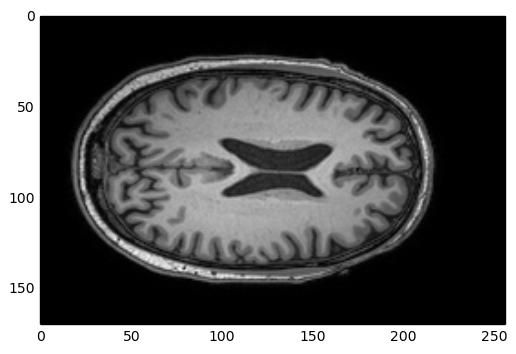

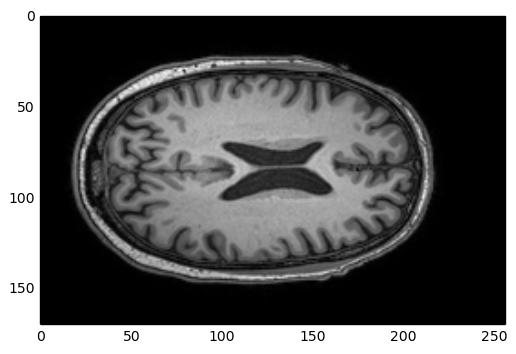

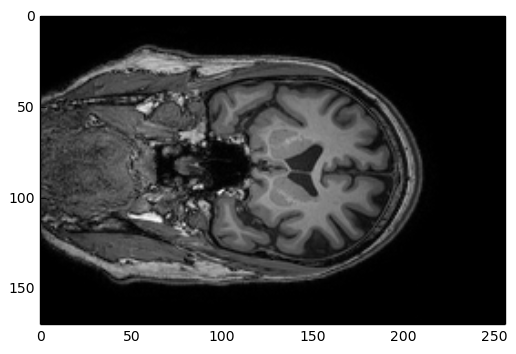

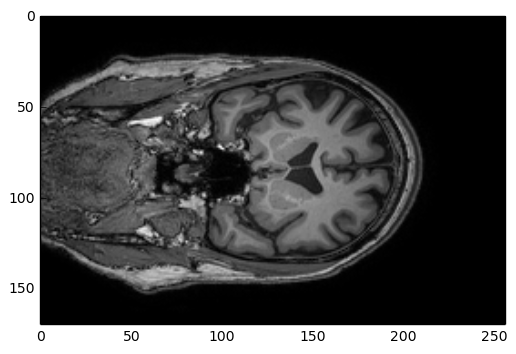

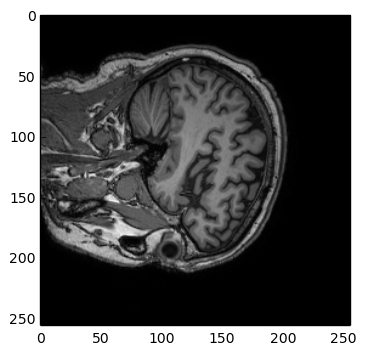

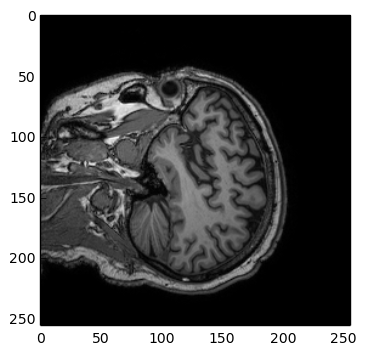

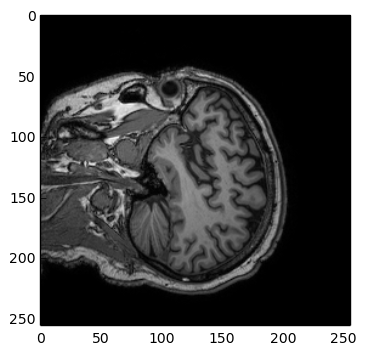

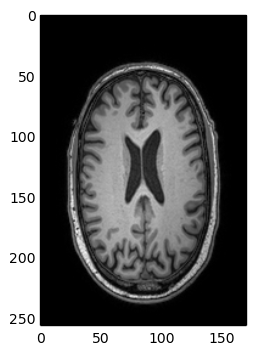

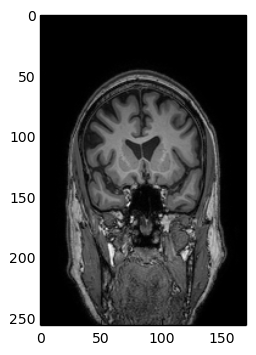

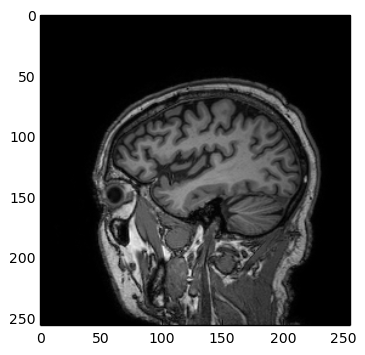

In [138]:
# display an image slice
plt.imshow(data[:,:,150,0], cmap="gray") # slicing from z gives top of head view
plt.show()

plt.imshow(data[::-1,:,150,0], cmap="gray") # flipped along the horiz axis
plt.show()

plt.imshow(data[:,150, :,0], cmap="gray") # slicing from y gives behind head view
plt.show()

plt.imshow(data[::-1,150, :,0], cmap="gray") # flipped along the horiz axis
plt.show()

plt.imshow(data[50,:,:,0], cmap="gray") # slicing from x gives side of head view
plt.show()

plt.imshow(data[50,::-1,:,0], cmap="gray") #flipped along the horiz axis
plt.show()

plt.imshow(np.flip(data[50,:,:,0], axis=0), cmap="gray") #flipped along the horiz axis
plt.show()


# rotate for ease of use of viewers (rotated, flipped images) (not sure why they display smaller...)
plt.imshow(np.rot90(data[::-1,:,150,0], k=1, axes=(0, 1)), cmap="gray")
plt.show()
plt.imshow(np.rot90(np.flip(data[:,150,:,0], axis=0), axes=(0, 1)), cmap="gray")
plt.show()
plt.imshow(np.rot90(np.flip(data[50,:,:,0], axis=0), axes=(0, 1)), cmap="gray")
plt.show()


In [139]:
# normalize data
# norm_data = data/np.max(data)# (data - np.mean(data))/np.std(data)
# plt.axis("off")
# plt.imshow(norm_data[:,:,150, 0], cmap="gray")
# plt.show()

(256, 170, 1024)
(1024,)


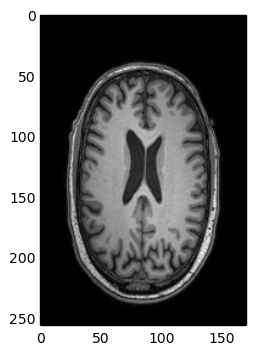

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [140]:
# slice data, rotate, flip, create labels (flipped/not)

# append all 2D 170x256 px slices together (axis=2 is the observation number axis)
all_slices = np.append(data[:, :, :, 0], np.swapaxes(data[:, :, :, 0], 1, 2), axis = 2)
n_slice = all_slices.shape[2]

# rotate for ease of use
all_slices = np.rot90(all_slices, axes = (0, 1))

# flip each slice over x axis
all_slices_flipped = np.flip(all_slices, axis = 1)

# final datasets
slice_data = np.append(all_slices, all_slices_flipped, axis = 2)
slice_labels = np.repeat(np.array([0, 1]), n_slice)

# check sizes
print(slice_data.shape)
print(slice_labels.shape)

# check visually
plt.imshow(slice_data[:,:,150], cmap="gray")
plt.show()
plt.imshow(slice_data[:,:,150 + n_slice/2], cmap="gray") 
plt.show()
plt.imshow(slice_data[:,:,150 + n_slice], cmap="gray")
plt.show()
plt.imshow(slice_data[:,:,150 + n_slice/2 + n_slice], cmap="gray") 
plt.show()

(256, 170, 1024)
(1024,)
(1024, 256, 170)


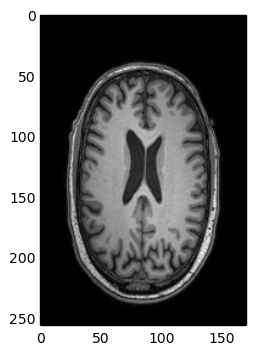

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [133]:
import tensorflow as tf

# Train nn on this small dataset and labels

# slice_data
# slice_labels

# reorder into initially N x H x W x C, where:
#    N is the number of datapoints
#    H is the height of each image in pixels
#    W is the height of each image in pixels
#    C is the number of channels (usually 3: R, G, B)

print(slice_data.shape)
print(slice_labels.shape)

all_data = np.rollaxis(slice_data, 2)
print(all_data.shape)

# check visually
plt.imshow(all_data[150,:,:], cmap="gray")
plt.show()
plt.imshow(all_data[150 + n_slice/2, :,:], cmap="gray") 
plt.show()
plt.imshow(all_data[150 + n_slice,:,:], cmap="gray")
plt.show()
plt.imshow(all_data[150 + n_slice/2 + n_slice,:,:], cmap="gray") 
plt.show()

# Randomize data/label pairs
order = sample(range(2*n_slice), 2*n_slice)
all_data_random = all_data[order, :, :]
all_labels_random = slice_labels[order]

# Add final axis to adhere to RGB channel convention
all_data_random = all_data[:, :, :, np.newaxis]

# Pad width with 0s to make 256 x 256 instead of 256 x 170 
#   (could change architecture)
all_data_random = np.pad(all_data_random, [(0, 0), (0, 0), (43, 43), (0, 0)], mode='constant')


print(all_data_random.shape)
print(all_labels_random.shape)

all_data_random = all_data_random.astype('float64')

# Make labels into one hot vectors
# all_labels_random_hot = np.zeros((2, 2*n_slice))
# all_labels_random_hot[all_labels_random, range(2*n_slice)] = 1

# Divide into train (4/6), test (1/6) , validation (1/6) (subsample?)
sixth = int(2*n_slice/6)

X_val = all_data_random[0:(sixth), :, :]
y_val = all_labels_random[0:(sixth)]
X_test = all_data_random[(sixth):(2*sixth), :, :]
y_test = all_labels_random[(sixth):(2*sixth)]
X_train = all_data_random[(2*sixth):, :, :]
y_train = all_labels_random[(2*sixth):]

# print(X_val.shape, X_test.shape, X_train.shape)
# print(type(X_val[0,0,0]))

# Normalize the data: subtract the mean training image
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [141]:
# The example model itself
# The first step to training your own model is defining its architecture.
# Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, 
#     remembering that each layer is composed upon the previous layer. 
#     We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up.
# In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). 
# You also see the Hinge loss function, and the Adam optimizer being used.
# Make sure you understand why the parameters of the Linear layer are 5408 and 10.
# TensorFlow Details
# In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network
# model.

# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 256, 256, 1]) # 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables # (W - F + 2P)/S + 1 = (256 - 8 + 0)/2 + 1 = 125 x 125 x 32
    Wconv1 = tf.get_variable("Wconv1", shape=[8, 8, 1, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[500000, 2]) # shape=[43520, 2]) # [5408, 10])
    b1 = tf.get_variable("b1", shape=[2])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1, 2, 2, 1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1, [-1,500000]) #5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,2),logits=y_out) # 10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

In [ ]:
# Training the model on one epoch
# While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and 
#    computing the results, we first need to create a tf.Session object.
#    A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow Getting 
#    started guide.
# Optionally we can also specify a device context such as /cpu:0 or /gpu:0. 
# For documentation on this behavior see this TensorFlow guide


def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [ ]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)

print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)